In [1]:
import pandas as pd
import torch
import torch_geometric as pyg

from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.loader import NeighborLoader

import pandas as pd
import networkx as nx
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

from tqdm import tqdm
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

/opt/homebrew/anaconda3/envs/network_ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_books = pd.read_csv('../data/books.csv')[['book_id', 'title', 'authors']]    # TODO: think about using also the columns
df_ratings = pd.read_csv('../data/ratings.csv')

Text(0.5, 1.0, 'Number of ratings per book')

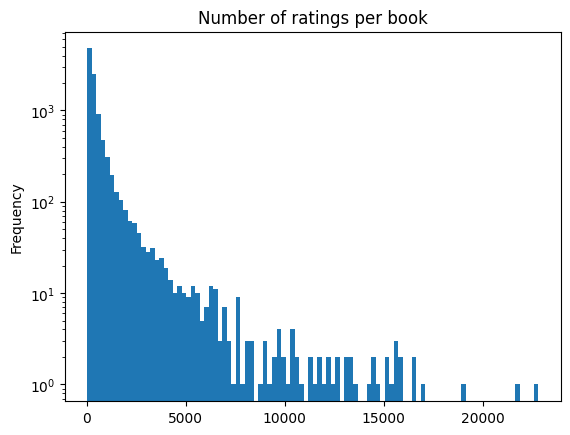

In [3]:
# order books by number of ratings
df_books_merged = df_books.merge(df_ratings.groupby('book_id').size().reset_index(name='n_ratings'), on='book_id')

# plot the number of ratings log scale
df_books_merged['n_ratings'].plot.hist(bins=100, log=True)
plt.title('Number of ratings per book')

It's a power law!!

In [4]:
df_books_merged.head(10)

,book_id,title,authors,n_ratings
0,1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,22806
1,2,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",21850
2,3,"Twilight (Twilight, #1)",Stephenie Meyer,16931
3,4,To Kill a Mockingbird,Harper Lee,19088
4,5,The Great Gatsby,F. Scott Fitzgerald,16604
5,6,The Fault in Our Stars,John Green,11264
6,7,The Hobbit,J.R.R. Tolkien,15558
7,8,The Catcher in the Rye,J.D. Salinger,14472
8,9,"Angels & Demons (Robert Langdon, #1)",Dan Brown,13451
9,10,Pride and Prejudice,Jane Austen,13445


Text(0.5, 1.0, 'Number of reviews per user')

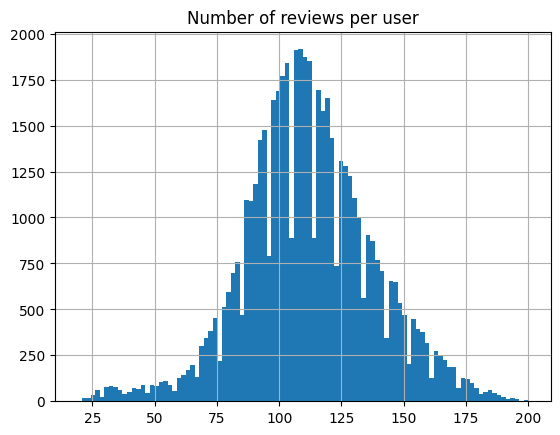

In [5]:
# plot the number of reviews per user
df_ratings.groupby('user_id').size().hist(bins=100)
plt.title('Number of reviews per user')

In [13]:
# print the number of connected components
G = nx.Graph()
G.add_edges_from(df_ratings[['user_id', 'book_id']].values)
print(nx.number_connected_components(G))

1


Text(0.5, 1.0, 'Rating distribution')

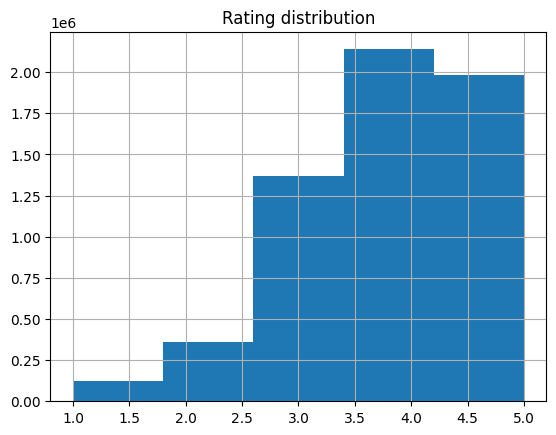

In [24]:
df_ratings.rating.hist(bins=5)
plt.title('Rating distribution')

Text(0.5, 1.0, 'Mean rating per book')

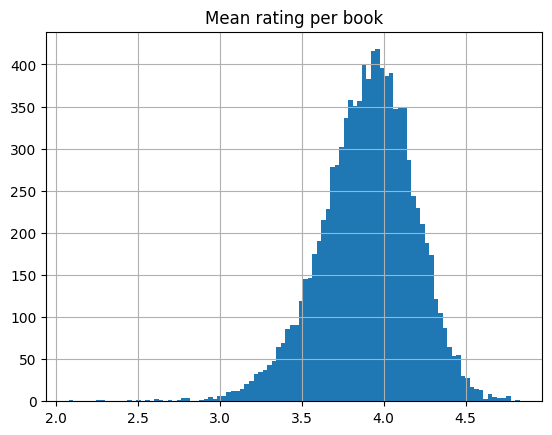

In [32]:
# are popular books rated higher?
mean_rating = df_ratings.groupby('book_id')['rating'].mean()
mean_rating.hist(bins=100)
plt.title('Mean rating per book')

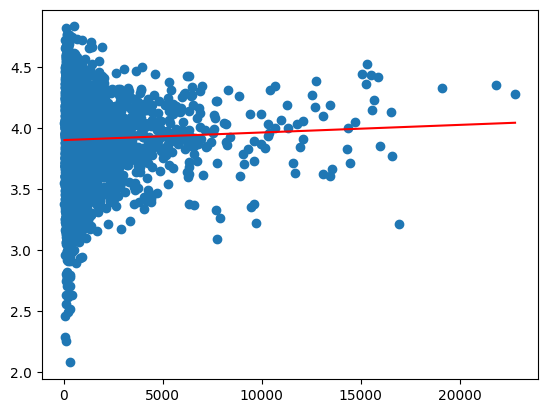

In [36]:
# are popular books rated higher? plot a linear line fitted on the mean ratings and number of ratings
plt.scatter(df_books_merged['n_ratings'], mean_rating)

m, b = np.polyfit(df_books_merged['n_ratings'], mean_rating, 1) # 1 is the degree of the polynomial (linear)
plt.plot(df_books_merged['n_ratings'], m*df_books_merged['n_ratings'] + b, color='red') # Add the regression line

plt.title('Mean rating per book vs number of ratings')

<Axes: >

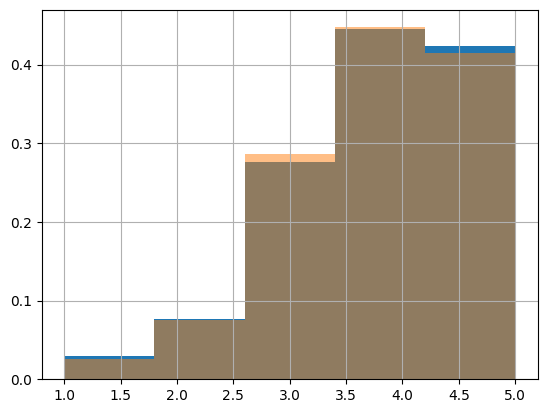

In [25]:
sampled_users = np.random.choice(df_ratings.user_id.unique(), 2000)
df_ratings_sampled = df_ratings[df_ratings.user_id.isin(sampled_users)]
df_ratings_sampled.rating.hist(bins=5, density=True)
df_ratings.rating.hist(bins=5, density=True, alpha=0.5)

Text(0.5, 1.0, 'Number of reviews per user')

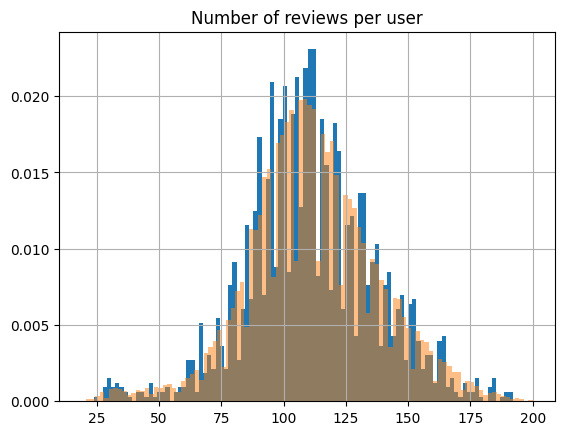

In [27]:
df_ratings_sampled.groupby('user_id').size().hist(bins=100, density=True)
df_ratings.groupby('user_id').size().hist(bins=100, density=True, alpha=0.5)
plt.title('Number of reviews per user')

There is almost no correlation between the number of ratings and the review. But as the number of ratings increase the variance of the rating decrease

## Ideas

Our aim is to create a recommender system which given a set of books which the user has rated it find a book which he hasn't read but he's most likely to like more. Most of the ratings are between 3.5 and 4.5 which make the learning more complicated. 

The most rated books are rated by almost half the user in our dataset, so they will be suggested with high probability to the users who haven't read them. This is why we should try to increase the diversity of the suggestions. 